## โหลดข้อมูล + ระบุคอลัมน์ label

In [26]:
import os, pandas as pd

IN_PATH = "./out/features_trainable_5cls.csv" 
OUT_DIR = "./out"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(IN_PATH)

# เดาชื่อคอลัมน์ label (แก้เองได้ถ้าใช้ชื่อเฉพาะ)
for cand in ["label", "label_final_5cls", "label_auto_5cls"]:
    if cand in df.columns:
        LABEL_COL = cand
        break
else:
    raise ValueError("ไม่พบคอลัมน์ label (ลองเปลี่ยน LABEL_COL ให้ตรงกับไฟล์)")

print("LABEL_COL =", LABEL_COL)
print(df[LABEL_COL].value_counts())
df.head(2)

LABEL_COL = label
label
WALK          1741
UPSTAIRS      1739
RUN           1306
DOWNSTAIRS    1249
IDLE          1212
Name: count, dtype: int64


,source_file,start_time,end_time,lin_acc_mag_dom_freq,lin_acc_mag_rms,vert_horiz_ratio,vert_lin_rms,horiz_lin_rms,lin_acc_mag_band05_5Hz,gyro_mag_rms,...,vert_neg_impulse,vert_impulse_ratio,vert_p95,vert_p05,vert_peak_ratio,vjerk_rms,vert_balance_bp,peak_balance_bp,file_key,label
0,cleaned_downstairs_ed_1.csv,2025-09-30 10:50:45.147717953,2025-09-30 10:50:47.147717953,2.474748,5.691099,0.854429,3.696945,4.326801,7833.623626,2.808906,...,-3.772527,0.397382,4.500975,-7.201538,0.625002,45.457745,-0.316204,-0.135934,cleaned_downstairs_ed_1,DOWNSTAIRS
1,cleaned_downstairs_ed_1.csv,2025-09-30 10:50:46.147717953,2025-09-30 10:50:48.147717953,0.989899,6.185855,0.544952,2.960008,5.431680,17291.158053,2.602030,...,-2.758334,0.640703,3.606363,-6.337401,0.569060,53.499067,-0.481609,-0.107081,cleaned_downstairs_ed_1,DOWNSTAIRS


## แบ่ง Train/Test (เลือกแบบปกติ หรือกันรั่วข้ามไฟล์)

In [27]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import numpy as np

TEST_SIZE     = 0.30
RANDOM_STATE  = 42
USE_GROUP_SPLIT = True   # ← ตั้งเป็น False ถ้าไม่ต้องการกันรั่วไฟล์

if not USE_GROUP_SPLIT:
    # แบบปกติ: stratify ต่อแถว
    train_df, test_df = train_test_split(
        df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df[LABEL_COL]
    )
else:
    # แบบกันรั่วไฟล์: แยก train/test ด้วยรายชื่อไฟล์ (source_file)
    if "source_file" not in df.columns:
        raise ValueError("ต้องมีคอลัมน์ 'source_file' สำหรับ split แบบ group-aware")

    # ระดับไฟล์: 1 ไฟล์ 1 แถว ใช้ mode ของ label เป็นป้ายของไฟล์
    file_level = (
        df.groupby("source_file")
          .agg(file_label=(LABEL_COL, lambda s: s.mode().iat[0]))
          .reset_index()
    )

    # --- แก้ error: กันคลาสที่มีไฟล์ < 2 ให้ไป train ทั้งหมดก่อน ---
    always_train_files = set()
    rest = file_level.copy()

    while True:
        counts = rest["file_label"].value_counts()
        bad_classes = counts[counts < 2].index.tolist()
        if not bad_classes:
            break
        # ย้ายไฟล์ของคลาสที่มีไฟล์น้อยกว่า 2 เข้า train
        move_files = set(rest.loc[rest["file_label"].isin(bad_classes), "source_file"])
        always_train_files |= move_files
        rest = file_level[~file_level["source_file"].isin(always_train_files)].reset_index(drop=True)
        if rest.empty:
            break
    # ---------------------------------------------

    if rest.empty:
        train_files = set(file_level["source_file"])
        test_files  = set()
    else:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        train_idx, test_idx = next(sss.split(rest[["source_file"]], rest["file_label"]))
        train_files = set(rest.iloc[train_idx]["source_file"]) | always_train_files
        test_files  = set(rest.iloc[test_idx]["source_file"])

    assert train_files.isdisjoint(test_files)
    train_df = df[df["source_file"].isin(train_files)].copy()
    test_df  = df[df["source_file"].isin(test_files)].copy()

print("Shapes:", train_df.shape, test_df.shape)
print("\nTrain % by class")
print((train_df[LABEL_COL].value_counts(normalize=True)*100).round(1))
print("\nTest % by class")
print((test_df[LABEL_COL].value_counts(normalize=True)*100).round(1))

# บันทึกชุดข้อมูล (คงรูปแบบเดิมของคุณไว้)
train_path = os.path.join(OUT_DIR, "train_5cls.csv" + ("_group" if USE_GROUP_SPLIT else ""))
test_path  = os.path.join(OUT_DIR, "test_5cls.csv"  + ("_group" if USE_GROUP_SPLIT else ""))
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)
print("\nSaved:", train_path, "and", test_path)

Shapes: (4437, 24) (2810, 24)

Train % by class
label
UPSTAIRS      27.9
WALK          26.5
DOWNSTAIRS    19.0
RUN           18.8
IDLE           7.8
Name: proportion, dtype: float64

Test % by class
label
IDLE          30.9
WALK          20.1
UPSTAIRS      17.8
RUN           16.7
DOWNSTAIRS    14.5
Name: proportion, dtype: float64

Saved: ./out/train_5cls.csv_group and ./out/test_5cls.csv_group


In [28]:
import os, pandas as pd

OUT_DIR = "./out"
train_path = os.path.join(OUT_DIR, "train_5cls.csv_group")  # ถ้าไม่ได้ใช้ group-aware เปลี่ยนชื่อไฟล์
test_path  = os.path.join(OUT_DIR, "test_5cls.csv_group")

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# เดาชื่อคอลัมน์ label (แก้เป็นชื่อที่คุณใช้จริงได้)
for cand in ["label_final_5cls","label","label_auto_5cls"]:
    if cand in train_df.columns:
        LABEL_COL = cand
        break
else:
    raise ValueError("ไม่พบคอลัมน์ label")

print("LABEL_COL =", LABEL_COL)
print("train size:", train_df.shape, "| test size:", test_df.shape)
print(train_df[LABEL_COL].value_counts())

LABEL_COL = label
train size: (4437, 24) | test size: (2810, 24)
label
UPSTAIRS      1238
WALK          1177
DOWNSTAIRS     842
RUN            836
IDLE           344
Name: count, dtype: int64


In [29]:
import numpy as np

META_COLS = {
    "source_file","start_time","end_time",
    "expected_file_class","expected_file_group",
    "label","label_auto_5cls","label_final_5cls"
}
meta_present = [c for c in META_COLS if c in train_df.columns]
feature_cols = [c for c in train_df.columns if c not in meta_present]

def prepare_X(df, feature_cols):
    X = df[feature_cols].copy()
    # บังคับเป็น numeric + เติมค่าหายด้วย median ต่อคอลัมน์
    for c in feature_cols:
        if not np.issubdtype(X[c].dtype, np.number):
            X[c] = pd.to_numeric(X[c], errors="coerce")
        if X[c].isna().any():
            X[c] = X[c].fillna(X[c].median())
    return X

X_train = prepare_X(train_df, feature_cols)
y_train = train_df[LABEL_COL].astype("category")
X_test  = prepare_X(test_df, feature_cols)
y_test  = test_df[LABEL_COL].astype("category")

print(len(feature_cols), "features prepared.")

20 features prepared.


/Users/disezmike/.pyenv/versions/3.13.2/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/disezmike/.pyenv/versions/3.13.2/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Create Model

Balanced accuracy: 0.894
              precision    recall  f1-score   support

  DOWNSTAIRS      0.812     0.744     0.777       407
        IDLE      1.000     1.000     1.000       868
         RUN      1.000     1.000     1.000       470
    UPSTAIRS      0.738     0.850     0.790       501
        WALK      0.946     0.876     0.910       564

    accuracy                          0.911      2810
   macro avg      0.899     0.894     0.895      2810
weighted avg      0.915     0.911     0.912      2810



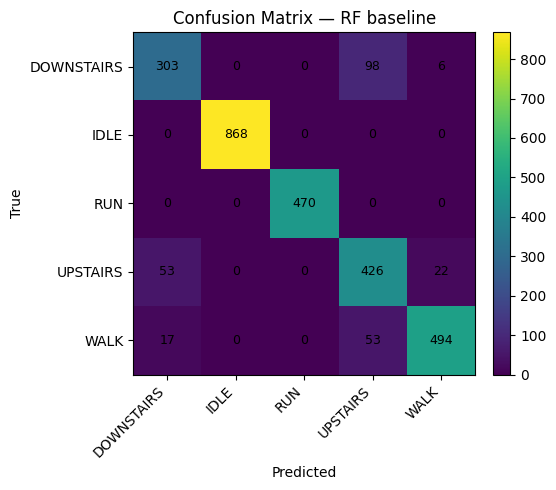

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import numpy as np, matplotlib.pyplot as plt

rf = RandomForestClassifier(
    n_estimators=500, max_depth=None, max_features="sqrt",
    class_weight="balanced", n_jobs=-1, random_state=42
)
rf.fit(X_train, y_train)

pred  = rf.predict(X_test)
proba = rf.predict_proba(X_test)

score = balanced_accuracy_score(y_test, pred)
print(f"Balanced accuracy: {score:.3f}")
print(classification_report(y_test, pred, digits=3))

labels = sorted(y_train.unique())
cm = confusion_matrix(y_test, pred, labels=labels)
plt.figure(figsize=(6,5))
im = plt.imshow(cm, interpolation="nearest"); plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
plt.title("Confusion Matrix — RF baseline")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

In [31]:
import joblib, os, datetime as dt
bundle = {
    "model": rf,              # หรือ rf_tuned ถ้าจูนแล้ว
    "features": feature_cols,
    "label_col": LABEL_COL,
    "trained_at": dt.datetime.now().isoformat(timespec="seconds"),
    "group_split": True
}
model_path = os.path.join(OUT_DIR, "rf_4cls.joblib")
joblib.dump(bundle, model_path)
print("Saved model to:", model_path)

Saved model to: ./out/rf_4cls.joblib


In [32]:
!pip install skl2onnx


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [34]:
# === Convert sklearn RF -> ONNX (no ZipMap) + rename outputs ===
import json, joblib, onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

bundle = joblib.load("./out/rf_4cls.joblib")
rf = bundle["model"]
feature_cols = bundle["features"]
classes = rf.classes_.tolist()

initial_types = [("input", FloatTensorType([None, len(feature_cols)]))]
# ปิด ZipMap เพื่อให้ได้ tensor N×C (ง่ายต่อการเรียกใช้บนมือถือ)
options = {id(rf): {"zipmap": False}}

onnx_model = convert_sklearn(
    rf,
    initial_types=initial_types,
    options=options,
    target_opset=17,   # ใช้ opset ทั่วไป (ปรับลงได้ถ้าเครื่องคุณต้องการ)
)

# เปลี่ยนชื่อเอาต์พุตให้เป็น 'label' และ 'probabilities'
# (index 0 = label, index 1 = probability tensor)
onnx_model.graph.output[0].name = "label"
onnx_model.graph.output[1].name = "probabilities"

# เซฟไฟล์โมเดล + meta
onnx.save(onnx_model, "./mobile/rf_4cls.onnx")
with open("./mobile/rf_4cls.meta.json", "w") as f:
    json.dump({"classes": classes, "features": feature_cols}, f, ensure_ascii=False, indent=2)

# ตรวจสอบชื่อเอาต์พุต (ควรได้ ['label', 'probabilities'])
print([o.name for o in onnx_model.graph.output])

['label', 'probabilities']
